In [1]:
# latest
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import Trainer, TrainingArguments
import torch
from transformers import pipeline
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from sentence_transformers import SentenceTransformer, util

2024-11-12 02:50:15.776050: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 02:50:15.789540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731360015.808290  702365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731360015.814167  702365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 02:50:15.834170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def ExactMatch(predicted_answers, reference_answers):
    return np.mean([1 if pred.lower().strip() == ref.lower().strip() else 0 for pred, ref in zip(predicted_answers, reference_answers)])

In [3]:
m = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
st_model = SentenceTransformer(m)

def SAS(predicted_answers, reference_answers):
    predictions_embeddings = st_model.encode(predicted_answers, convert_to_tensor=True)
    reference_embeddings = st_model.encode(reference_answers, convert_to_tensor=True)
    similarity_scores = [util.cos_sim(p, l).cpu().numpy() for p, l in zip(predictions_embeddings, reference_embeddings)]
    return np.mean(similarity_scores)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [119]:
df = pd.read_csv("training_data_en.csv",sep=";",on_bad_lines='skip')

In [120]:
df = df.sample(frac=1)

In [121]:
# df['Text'][0].split()

In [122]:
list(df)

['ID', 'Text', 'Question', 'Answer']

In [123]:
df['Text'] = df['Text'].apply(lambda x:x.lower())
df['Question'] = df['Question'].apply(lambda x:x.lower())
df['Answer'] = df['Answer'].apply(lambda x:x.lower())

In [124]:
df['Text'] = df['Text'].apply(lambda x: ' '.join(x.split()))
df['Question'] = df['Question'].apply(lambda x: ' '.join(x.split()))
df['Answer'] = df['Answer'].apply(lambda x: ' '.join(x.split()))

In [125]:
df = df[df.apply(lambda x:x.Answer.lower() in x.Text.lower(),axis=1)]

In [126]:
def convert_to_squad_format(data):
    squad_data = []
    
    for entry in data:
        context = entry['Text']
        question = entry['Question']
        answer = entry['Answer']

        
        answer_start = context.find(answer)
        if answer_start == -1:
            print(f"Answer '{answer}' not found in context.")
            continue

        # Calculate the end index of the answer
        answer_end = answer_start + len(answer)

        # Add the entry in SQuAD format
        squad_entry = {
            'ID': entry['ID'],
            'context': context,
            'question': question,
            'answer': answer,
            'answer_start': answer_start,
            'answer_end': answer_end
        }
        squad_data.append(squad_entry)
    
    return squad_data

In [127]:
df = Dataset.from_pandas(df)
train_data = convert_to_squad_format(df)
train_df = pd.DataFrame(train_data)
print(train_df.shape)

(1986, 6)


In [128]:
train_df = train_df.sample(frac=1)

In [129]:
train_df.shape

(1986, 6)

In [130]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
print(train_df.shape,val_df.shape)

(1787, 6) (199, 6)


In [131]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
datasets = DatasetDict({"train": train_dataset, "validation": val_dataset})

In [132]:
datasets['train'][0]

{'ID': '3562.b',
 'context': 'the group has continued to deliver further sustained improvements in working capital during the year which, together with the robust trading performance, has resulted in strong underlying cash generation. net debt has increased by £3.1 million as a result of £9.2 million of net capital',
 'question': 'what led to net debt increasing by £3.1 million?',
 'answer': '£9.2 million of net capital',
 'answer_start': 259,
 'answer_end': 286,
 '__index_level_0__': 606}

In [133]:
# Load the pretrained tokenizer and model
model_name = "consciousAI/question-answering-roberta-base-s"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
model.to(device)

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

In [134]:
def preprocess_function(examples):
    inputs = tokenizer(
        examples["question"], 
        examples["context"], 
        max_length=384, 
        truncation="only_second", 
        padding="max_length", 
        return_offsets_mapping=True
    )
    
    start_positions = []
    end_positions = []
    
    for i, offset_mapping in enumerate(inputs["offset_mapping"]):
        start_char = examples["answer_start"][i]
        end_char = start_char + len(examples["answer"][i])

        # Initialize token positions
        token_start = token_end = None
        for j, (start, end) in enumerate(offset_mapping):
            if start <= start_char < end:
                token_start = j
            if start < end_char <= end:
                token_end = j + 1
                break
         # Ensure token positions are not None
        if token_start is not None and token_end is not None:
            start_positions.append(token_start)
            end_positions.append(token_end)
        else:
            # Skip example if positions are invalid
            print(f"Warning: Could not find answer positions in tokenized context for example {i}")
            start_positions.append(0)  # or any default index
            end_positions.append(0) 
#         start_positions.append(token_start)
#         end_positions.append(token_end)
    
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    inputs.pop("offset_mapping")  # Remove as it's not needed for training

    return inputs

In [135]:
tokenized_datasets = datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/1787 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

In [139]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['ID', 'context', 'question', 'answer', 'answer_start', 'answer_end', '__index_level_0__', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1787
    })
    validation: Dataset({
        features: ['ID', 'context', 'question', 'answer', 'answer_start', 'answer_end', '__index_level_0__', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 199
    })
})

In [140]:
# t = pd.DataFrame(tokenized_datasets['train'])

In [141]:
# t.shape

In [142]:
# t = t[t.apply(lambda x: not (x.start_positions==0 and x.end_positions==0),axis=1)]

In [143]:
# t.shape

In [144]:
# d = pd.DataFrame(tokenized_datasets['validation'])
# d = d[d.apply(lambda x: not (x.start_positions==0 and x.end_positions==0),axis=1)]

In [145]:
# d.shape

In [146]:
# from datasets import Dataset, DatasetDict
# t.drop(columns='__index_level_0__',inplace=True)
# d.drop(columns='__index_level_0__',inplace=True)

In [147]:
# # Convert DataFrames to Hugging Face Datasets
# train_dataset = Dataset.from_pandas(t)
# val_dataset = Dataset.from_pandas(d)

# # Create the DatasetDict
# dataset_dict = DatasetDict({
#     'train': train_dataset,
#     'validation': val_dataset
# })

In [148]:
# tokenized_datasets = dataset_dict

In [149]:
# tokenized_datasets

In [150]:
from transformers import Trainer, TrainingArguments
import numpy as np
from sentence_transformers import SentenceTransformer, util

In [151]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=10,
#     report_to="none"
# )


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    save_strategy="epoch",  # Save model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="eval_loss",  # Metric to use for selecting the best model
)


# Effective Batch Size:   48 

# Batch Size per GPU:     3 
# No. of GPU:             8 
# Update Freq.:           2

# Max Epochs:             2
# Total No. of Updates:   5430
# Warmup ratio:           0.06
# Warmup Updates:         326

# Learning Rate:          1.5e-5 
# Weight Decay:           0.01 
# Learning Rate Decay:    Linear
# Adam eps:               1e-6


/home/sarang/.local/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [152]:
trainer = Trainer(
    model=model,
    args=training_args,
    # compute_metrics=compute_metrics,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"]
)

In [153]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.829300,0.688917
2,0.410700,0.645484
3,0.244700,0.724772


TrainOutput(global_step=672, training_loss=0.6439378016761371, metrics={'train_runtime': 117.1764, 'train_samples_per_second': 45.752, 'train_steps_per_second': 5.735, 'total_flos': 1050608934646272.0, 'train_loss': 0.6439378016761371, 'epoch': 3.0})

In [154]:
# Save the model after training
trainer.save_model("final_model")  # Save the model to the specified path
tokenizer.save_pretrained("final_model")  # Save the tokenizer

('final_model/tokenizer_config.json',
 'final_model/special_tokens_map.json',
 'final_model/vocab.json',
 'final_model/merges.txt',
 'final_model/added_tokens.json',
 'final_model/tokenizer.json')

In [155]:
import re

def clean_answer(text):
    """Remove trailing punctuation from predictions."""
    return re.sub(r'[\.,;]+$', '', text.strip())

In [156]:
def postprocess_predictions(examples, features, raw_predictions):
    all_start_logits, all_end_logits = raw_predictions
    predictions = []
    
    for i, example in enumerate(examples):
        start_logits = all_start_logits[i]
        end_logits = all_end_logits[i]
        
        start_idx = torch.argmax(torch.tensor(start_logits)).item()
        end_idx = torch.argmax(torch.tensor(end_logits)).item() + 1
        
        prediction = tokenizer.decode(features[i]["input_ids"][start_idx:end_idx],skip_special_tokens=True)
        prediction = clean_answer(prediction)
        predictions.append({"id": example["ID"],"Text":example["context"],"Question":example["question"], "Answer": prediction})
    
    return predictions

In [157]:
%%time
raw_predictions = trainer.predict(tokenized_datasets["validation"])

CPU times: user 1.12 s, sys: 11.9 ms, total: 1.13 s
Wall time: 1.13 s


In [158]:
# Post-process predictions
# `examples` should be the original validation data (non-tokenized)
# `features` are the tokenized inputs for the validation data
examples = tokenized_datasets["validation"]
features = tokenized_datasets["validation"].map(preprocess_function, batched=True)

# Generate formatted predictions using the postprocessing function
predictions = postprocess_predictions(examples, features, raw_predictions.predictions)

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

In [159]:
reference_answers = [ex["answer"] for ex in examples]
predicted_answers = [pred["Answer"] for pred in predictions]
em_score = ExactMatch(predicted_answers, reference_answers)

print(f"Exact Match on validation set: {em_score:.2%}")

Exact Match on validation set: 72.36%


In [160]:
SAS(predicted_answers, reference_answers)

0.94819677

In [161]:
len(examples)

199

In [ ]:
# for i,j in zip(reference_answers,predicted_answers):
#     print(i)
#     print(j)
#     print("____________________________________________________________________")

In [162]:
def convert_to_squad_format(data, has_answers=False):
    squad_data = []
    
    for entry in data:
        context = entry['Text']
        question = entry['Question']
        
        if has_answers:
            answer = entry['Answer']
            answer_start = context.find(answer)
            if answer_start == -1:
#                 print(f"Answer '{answer}' not found in context.")
                continue
            answer_end = answer_start + len(answer)
        else:
            # For test data, set default values for answer fields
            answer = ""
            answer_start = -1
            answer_end = -1

        squad_entry = {
            'ID': entry['ID'],
            'context': context,
            'question': question,
            'answer': answer,
            'answer_start': answer_start,
            'answer_end': answer_end
        }
        squad_data.append(squad_entry)
    
    return squad_data

In [163]:
# Load the test data
test_df = pd.read_csv("input_data_evaluation_en.csv", sep=";")

test_df = Dataset.from_pandas(test_df)
test_data = convert_to_squad_format(test_df)
test_dataset = Dataset.from_pandas(pd.DataFrame(test_data))
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

In [164]:
%%time
predictions = trainer.predict(tokenized_test_dataset)

CPU times: user 2.75 s, sys: 13.8 ms, total: 2.77 s
Wall time: 2.76 s


In [165]:
# Post-process and save test predictions
test_predictions = postprocess_predictions(test_data, tokenized_test_dataset, predictions.predictions)
test_predictions_df = pd.DataFrame(test_predictions)

In [166]:
pd.set_option('display.max_colwidth', None)
test_predictions_df

,id,Text,Question,Answer
0,2759,The fees of the non-executive directors and the Chairman were reviewed in 2017 and as a result no increase will be made in 2018.,What was the consequence of the 2017 review of the fees for non-executive directors and the Chairman?,no increase will be made in 2018
1,2259.a,The Directors believe that due to the size and nature of the Company it would be unnecessarily burdensome to establish a separate remuneration committee. Remuneration matters are therefore included in matters reserved for the Board.,What factors make the Directors believe it is unnecessary to establish a separate remuneration committee?,the size and nature of the Company it
2,2123.a,"Owing to the Company's REIT status, income and capital gains from our property rental business are exempt from corporation tax, therefore, the tax charge for the year is nil.",What does the Company's REIT status result in?,income and capital gains from our property rental business are exempt from corporation tax
3,1882.b,"Underlying Group EBITDA declined by 10.1% to £10.0m (2016: £11.2m). This decline has been driven by an increase in UK overheads of £1.0m (5.6%), due to investment in support of our strategic initiatives and well-publicised cost headwinds.","What has motivated the increase in UK overheads by £1.0 million, or 5.6%?",investment in support of our strategic initiatives and well-publicised cost headwinds
4,1117,No further disclosure is provided for deductions due to the materiality of the numbers.,What reason drives them not to provide disclosure for deductions?,the materiality of the numbers
...,...,...,...,...
493,5148,"Following an extensive process, your Board reached agreement with the Board of Sibanye-Stillwater on the terms of the all-share offer for your Company which we announced on 14 December 2017. The full details of that offer are set out in that announcement and a Scheme Circular will be sent to each shareholder in due course. It is important that all shareholders read and consider the Scheme Circular in full. Your Board recommended the offer from Sibanye-Stillwater because we believe it to be in the best interests of Lonmin shareholders and all the other stakeholders in your Company.",What explains the Board recommending the offer from Sibanye-Stillwater?,we believe it to be in the best interests of Lonmin shareholders and all the other stakeholders in your Company
494,9084,"Supporting the Company's current phase of development and strategy, remuneration is clearly biased towards performance-related elements that are aligned with continued delivery of improved levels of profitable growth and thus returns to our shareholders.",Why does the Company remain committed to delivering consistent returns to its shareholders?,"Supporting the Company's current phase of development and strategy, remuneration is clearly biased towards performance-related elements that are aligned with continued delivery of improved levels of profitable growth and"
495,9087,"Finally, we pledged to enhance the alignment of interests of management and shareholders, and as such have increased shareholding requirements to 1,000% of salary for the CEO and 350% for the CFO.","What was the reason behind increasing the shareholding requirements to 1,000% of the CEO's salary and 350% for the CFO?",we pledged to enhance the alignment of interests of management and shareholders
496,9088.a,"Following Savills Investment Management's record result in 2016, the expected decrease in disposal activity from the liquidating SEB German Open Ended Funds caused revenue to decrease by 8% (11% in constant currency) to £66.5m (2016: £72.0m). This generated an underlying profit of £13.3m (2016: £17.6m).","What factor drove the 8% decline in revenue to £66.5m, down from £72.0m in 2016?",the expected decrease in disposal activity from the liquidating SEB German Open Ended Funds caused


In [170]:
test_predictions_df.to_csv("results_en_final_v1.csv", index=False, sep=";")

# Load test_predictions_df

In [1]:
import pandas as pd

In [14]:
test_predictions_df = pd.read_csv('results_en_final_v1.csv',sep=";")

In [15]:
test_predictions_df.isna().sum()

id          0
Text        0
Question    0
Answer      9
dtype: int64

In [16]:
test_predictions_df['Answer'] = test_predictions_df['Answer'].fillna('')

In [17]:
# t_empty = test_predictions_df[test_predictions_df['Answer'].isna()]

In [18]:
t_empty = test_predictions_df[test_predictions_df['Answer'].apply(lambda x:len(x)==0)]

In [19]:
t_empty.index

Index([58, 69, 117, 118, 164, 186, 290, 342, 481], dtype='int64')

In [20]:
t_generative = test_predictions_df[test_predictions_df.apply(lambda x:x.Answer.lower() not in x.Text.lower(),axis=1)]

In [21]:
t_generative.index

Index([27, 42, 103, 126, 161, 223, 235, 323, 327, 424, 470], dtype='int64')

In [50]:
wrong_ans_index = t_generative.index.tolist() + t_empty.index.tolist()
wrong_ans_index

# LLM

In [23]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import os
import openai
from tqdm.notebook import tqdm
from openai import OpenAI

In [24]:
messages2 = lambda cntxt,qstn: [
    {
        "role": "system",
        "content": """
        You are an AI assistant specialized in Finance Causal extraction. Your task is to identify and return either the cause or effect as requested, verbatim, from the provided financial text.
        
        Guidelines:
        - Focus on extractive responses only—do not add or modify text outside the given context.No added words or rephrasing.
        - Ensure responses follow the cause-and-effect relationship: a cause precedes an effect, and an effect follows a cause.

        Examples:
        
        Example 1:
        CONTEXT: Nationwide is in robust financial health, having achieved profits of over £1 billion for the third consecutive year. Profits allow us to maintain our financial strength, invest with confidence, and return value to members through pricing and service.
        QUESTION: What is the effect of achieving profits of over £1 billion for the third consecutive year?
        ANSWER: Nationwide is in robust financial health

        Example 2:
        CONTEXT: All the Directors are resident in the UK, bringing a wide range of skills to the Board. Given the Company's small size and that the Board is comprised of only five Directors, all are members of the Audit Committee and the Nomination and Remuneration Committee.
        QUESTION: What is the impact of the Company's small size and having a Board comprised of only five independent Directors?
        ANSWER: the Board considers it sensible for all the Directors to be members of the Audit Committee and of the Nomination and Remuneration Committee
        
        Example 3:
        CONTEXT: Following a thorough and comprehensive review, we believe that our Remuneration Policy continues to be appropriate, and are therefore proposing the Policy remains broadly unchanged. In recognition of emerging best practice, we have updated our Policy to reduce the pension contribution for new Executive Director appointments to 15%.
        QUESTION: What impact had the thorough and comprehensive review?
        ANSWER: we believe that our Remuneration Policy continues to be appropriate

        Example 4:
        CONTEXT: As the Board consists entirely of non-executive directors it is considered appropriate that matters relating to remuneration are considered by the Board as a whole, rather than a separate remuneration committee. All directors are considered independent with the exception of Oliver Bedford who is an employee of Hargreave Hale Limited and is not therefore independent.
        QUESTION: What is the reason Oliver Bedford is the only director not deemed as independent?
        ANSWER: All directors are considered independent with the exception of Oliver Bedford who is an employee of Hargreave Hale Limited
        """
    },
    {
        "role": "user",
        "content": f"""
        ### Instruction
        You will be given a financial text in ### Context.
        
        ### Definitions
        - Cause: The reason why an event occurs.
        - Effect: The event that happens as a result of the cause.
        
        ### Context: {cntxt}
        ### Question: {qstn}
        ### Answer:
        """
    }
]


In [52]:
def get_predicted_linker(cntxt,qstn):
    completion = client.chat.completions.create(
        model= 'gemma-2-9b-it', #'llama-3.1-8b-instant',# chatgpt cheapest and efficient -> "gpt-4o-mini",
        # stop = ["\n\n", "<|endoftext|>", "<end_of_turn>"],
        stop = ["<start_of_turn>","<end_of_turn>"],
        messages= messages2(cntxt,qstn),
        temperature = 0
    )

    # print(messages2(temp_df,cntxt,qstn))
    return completion.choices[0].message.content

In [53]:
client = openai.OpenAI(

    # base_url = 'https://api.groq.com/openai/v1',
    base_url="http://127.0.0.1:1337/v1",
    # base_url="http://localhost:8080/v1", # "http://<Your api-server IP>:port"
    api_key = "sk-no-key-required"
)

In [54]:
models = client.models.list()
[i.id for i in models.data if 'gemma' in i.id]

['gemma-1.1-2b-it',
 'gemma-1.1-7b-it',
 'gemma-2-27b-it',
 'gemma-2-2b-it',
 'gemma-2-9b-it',
 'gemma-2-9b-it-Q5_K_M',
 'gemma-7b-it',
 'gemma_2b_it_QA_tuned_output_file']

In [55]:
df_temp = test_predictions_df.copy()

In [56]:
# df['Predicted_Answer'] = None
for line,row in tqdm(df_temp.iterrows()):

    if line in wrong_ans_index:
        print(line)
        context = row['Text']
        qstn = row['Question']
        a = get_predicted_linker(context,qstn)
        df_temp.at[line, 'Answer'] = a

0it [00:00, ?it/s]

27
42
58
69
103
117
118
126
161
164
186
223
235
290
323
327
342
424
470
481


In [31]:
pd.set_option('display.max_colwidth', None)

In [57]:
df_temp.iloc[wrong_ans_index]

,id,Text,Question,Answer
27,1635,"The Company incurs significant costs as a result of intellectual property disputes – the Company's ability to compete depends in part, upon the successful protection of its intellectual property.",What do intellectual property disputes translate to?,significant costs \n
42,3030,The index grew by 8.6% on an annualised basis. Jupiter's annualised underlying EPS growth did not therefore exceed the index by 5%.,What reason led to Jupiter's annualized underlying EPS growth not exceeding the index by 5%?,The index grew by 8.6% on an annualised basis. \n
103,828,"As noted in the Strategic Report, all of the Directors are non-executive and therefore there is no Chief Executive Officer (""CEO""). The Company does not have any employees. There is therefore no CEO or employee information to disclose.",Why is there no Chief Executive Officer?,"As noted in the Strategic Report, all of the Directors are non-executive \n"
126,3667.b,"Gross margins declined primarily as a result of the revenue mix, which included an increase in lower margin partnered services and disposal revenues as we optimised our hire fleet.",What was the effect of them optimizing their hire fleet?,Gross margins declined \n
161,2858,"Trading property is carried on the consolidated balance sheet at the lower of cost and market value, therefore valuation surpluses on trading property are not recorded. Any unrecognised surplus is however reflected within the EPRA net asset value measure.",Why are valuation surpluses on trading property not recorded?,Trading property is carried on the consolidated balance sheet at the lower of cost and market value \n
223,2410,Energy prices remain uncertain and for that reason we forward sell our generation (from which we earned revenues of £18.5m in the year) for the coming year to provide earnings,Why do they forward sell their generation for the coming year to provide earnings?,Energy prices remain uncertain \n
235,4080,The GB supply chain investment programme will further improve the flexibility and therefore resilience of our GB supply chain.,What is the consequence of the GB supply chain investment program further improving the flexibility of their GB supply chain?,the resilience of our GB supply chain \n
323,1821,"Foreign exchange rate movements had a favourable effect on revenues of approximately £2.7m on account of the weakening of Sterling against the Euro and US Dollar. On a constant currency basis, the Group delivered a like-for-like sales increase of 3.2%.",What was the outcome of the weakening of Sterling against the Euro and US Dollar?,Foreign exchange rate movements had a favourable effect on revenues of approximately £2.7m \n
327,2238,"Revenue for Gleeson Strategic Land increased by £1.5m to £29.9m, due to the increased sales activity during the year and mix of sites sold. Highlights • Revenue increased by 12.9% to £160.4m • Gross margin on Gleeson Homes unit sales increased to 33.0% from 31.1%.",What did the increased sales activity during the year and mix of sites sold bring about?,Revenue for Gleeson Strategic Land increased by £1.5m to £29.9m \n
424,1178,Revenue from our Strategic Marketing segment increased by 13% as a result of both strong organic and acquisitive growth.,What did strong organic and acquisitive growth lead to?,Revenue from our Strategic Marketing segment increased by 13% \n


In [58]:
df_temp['Answer'] = df_temp['Answer'].apply(lambda x:x.strip())
df_temp['Answer'] = df_temp['Answer'].apply(lambda x: x[:-1] if x[-1]=='.' else x)
df_temp['Answer'] = df_temp['Answer'].apply(lambda x: x.replace("Answer:",'') if x.startswith('Answer:') else x)

In [59]:
df_temp.iloc[wrong_ans_index]

,id,Text,Question,Answer
27,1635,"The Company incurs significant costs as a result of intellectual property disputes – the Company's ability to compete depends in part, upon the successful protection of its intellectual property.",What do intellectual property disputes translate to?,significant costs
42,3030,The index grew by 8.6% on an annualised basis. Jupiter's annualised underlying EPS growth did not therefore exceed the index by 5%.,What reason led to Jupiter's annualized underlying EPS growth not exceeding the index by 5%?,The index grew by 8.6% on an annualised basis
103,828,"As noted in the Strategic Report, all of the Directors are non-executive and therefore there is no Chief Executive Officer (""CEO""). The Company does not have any employees. There is therefore no CEO or employee information to disclose.",Why is there no Chief Executive Officer?,"As noted in the Strategic Report, all of the Directors are non-executive"
126,3667.b,"Gross margins declined primarily as a result of the revenue mix, which included an increase in lower margin partnered services and disposal revenues as we optimised our hire fleet.",What was the effect of them optimizing their hire fleet?,Gross margins declined
161,2858,"Trading property is carried on the consolidated balance sheet at the lower of cost and market value, therefore valuation surpluses on trading property are not recorded. Any unrecognised surplus is however reflected within the EPRA net asset value measure.",Why are valuation surpluses on trading property not recorded?,Trading property is carried on the consolidated balance sheet at the lower of cost and market value
223,2410,Energy prices remain uncertain and for that reason we forward sell our generation (from which we earned revenues of £18.5m in the year) for the coming year to provide earnings,Why do they forward sell their generation for the coming year to provide earnings?,Energy prices remain uncertain
235,4080,The GB supply chain investment programme will further improve the flexibility and therefore resilience of our GB supply chain.,What is the consequence of the GB supply chain investment program further improving the flexibility of their GB supply chain?,the resilience of our GB supply chain
323,1821,"Foreign exchange rate movements had a favourable effect on revenues of approximately £2.7m on account of the weakening of Sterling against the Euro and US Dollar. On a constant currency basis, the Group delivered a like-for-like sales increase of 3.2%.",What was the outcome of the weakening of Sterling against the Euro and US Dollar?,Foreign exchange rate movements had a favourable effect on revenues of approximately £2.7m
327,2238,"Revenue for Gleeson Strategic Land increased by £1.5m to £29.9m, due to the increased sales activity during the year and mix of sites sold. Highlights • Revenue increased by 12.9% to £160.4m • Gross margin on Gleeson Homes unit sales increased to 33.0% from 31.1%.",What did the increased sales activity during the year and mix of sites sold bring about?,Revenue for Gleeson Strategic Land increased by £1.5m to £29.9m
424,1178,Revenue from our Strategic Marketing segment increased by 13% as a result of both strong organic and acquisitive growth.,What did strong organic and acquisitive growth lead to?,Revenue from our Strategic Marketing segment increased by 13%


In [60]:
df_temp[df_temp.apply(lambda x:x.Answer.lower().strip() not in x.Text.lower().strip(),axis=1)]

,id,Text,Question,Answer
235,4080,The GB supply chain investment programme will further improve the flexibility and therefore resilience of our GB supply chain.,What is the consequence of the GB supply chain investment program further improving the flexibility of their GB supply chain?,the resilience of our GB supply chain
470,1923.a,"People costs continue to be the largest component of operating expenses and have risen 31% year-on-year due to new store growth and the further expansion of our specialist support functions. Occupancy costs increased 19% to £30.9 million, as a result of the store openings.",What was the consequence of new store growth and the further expansion of their specialist support functions?,People costs have risen 31% year-on-year


In [61]:
list(df_temp)

['id', 'Text', 'Question', 'Answer']

In [62]:
df_temp.columns = ['ID', 'Text', 'Question', 'Answer']

In [63]:
df_temp.to_csv("results_en_final_v3.csv", index=False, sep=";")

# EXTRA

In [51]:
df_temp

,ID,Text,Question,Answer
0,2759,The fees of the non-executive directors and the Chairman were reviewed in 2017 and as a result no increase will be made in 2018.,What was the consequence of the 2017 review of the fees for non-executive directors and the Chairman?,no increase will be made in 2018
1,2259.a,The Directors believe that due to the size and nature of the Company it would be unnecessarily burdensome to establish a separate remuneration committee. Remuneration matters are therefore included in matters reserved for the Board.,What factors make the Directors believe it is unnecessary to establish a separate remuneration committee?,the size and nature of the Company it
2,2123.a,"Owing to the Company's REIT status, income and capital gains from our property rental business are exempt from corporation tax, therefore, the tax charge for the year is nil.",What does the Company's REIT status result in?,income and capital gains from our property rental business are exempt from corporation tax
3,1882.b,"Underlying Group EBITDA declined by 10.1% to £10.0m (2016: £11.2m). This decline has been driven by an increase in UK overheads of £1.0m (5.6%), due to investment in support of our strategic initiatives and well-publicised cost headwinds.","What has motivated the increase in UK overheads by £1.0 million, or 5.6%?",investment in support of our strategic initiatives and well-publicised cost headwinds
4,1117,No further disclosure is provided for deductions due to the materiality of the numbers.,What reason drives them not to provide disclosure for deductions?,the materiality of the numbers
...,...,...,...,...
493,5148,"Following an extensive process, your Board reached agreement with the Board of Sibanye-Stillwater on the terms of the all-share offer for your Company which we announced on 14 December 2017. The full details of that offer are set out in that announcement and a Scheme Circular will be sent to each shareholder in due course. It is important that all shareholders read and consider the Scheme Circular in full. Your Board recommended the offer from Sibanye-Stillwater because we believe it to be in the best interests of Lonmin shareholders and all the other stakeholders in your Company.",What explains the Board recommending the offer from Sibanye-Stillwater?,we believe it to be in the best interests of Lonmin shareholders and all the other stakeholders in your Company
494,9084,"Supporting the Company's current phase of development and strategy, remuneration is clearly biased towards performance-related elements that are aligned with continued delivery of improved levels of profitable growth and thus returns to our shareholders.",Why does the Company remain committed to delivering consistent returns to its shareholders?,"Supporting the Company's current phase of development and strategy, remuneration is clearly biased towards performance-related elements that are aligned with continued delivery of improved levels of profitable growth and"
495,9087,"Finally, we pledged to enhance the alignment of interests of management and shareholders, and as such have increased shareholding requirements to 1,000% of salary for the CEO and 350% for the CFO.","What was the reason behind increasing the shareholding requirements to 1,000% of the CEO's salary and 350% for the CFO?",we pledged to enhance the alignment of interests of management and shareholders
496,9088.a,"Following Savills Investment Management's record result in 2016, the expected decrease in disposal activity from the liquidating SEB German Open Ended Funds caused revenue to decrease by 8% (11% in constant currency) to £66.5m (2016: £72.0m). This generated an underlying profit of £13.3m (2016: £17.6m).","What factor drove the 8% decline in revenue to £66.5m, down from £72.0m in 2016?",the expected decrease in disposal activity from the liquidating SEB German Open Ended Funds caused


In [68]:
messages1 = lambda context,question,answer: [
        {"role": "system", "content": "You are a helpful assistant that provides accurate and improved answers."},
        
        {"role": "user", "content": f"""
        You are given a Context, a Question, and an Answer.

        1. If the Answer is 100% correct and is extracted verbatim from the Context, return the exact same Answer.
        2. If the Answer is incorrect or not fully extracted from the Context, return an improved version of the Answer that is extracted verbatim from the Context.

        Context: {context}
        Question: {question}
        Answer: {answer}
        """}
    ]

In [69]:
def get_predicted_linker1(cntxt,qstn,ans):
    completion = client.chat.completions.create(
        model= 'gemma-2-9b-it', #'llama-3.1-8b-instant',# chatgpt cheapest and efficient -> "gpt-4o-mini",
        # stop = ["\n\n", "<|endoftext|>", "<end_of_turn>"],
        stop = ["<start_of_turn>","<end_of_turn>"],
        messages= messages1(cntxt,qstn,ans),
        temperature = 0
    )

    # print(messages2(temp_df,cntxt,qstn))
    return completion.choices[0].message.content

In [70]:
df_new = df_temp.copy()

In [71]:
df_new['Predicted_Answer'] = None
for line,row in tqdm(df_new.iterrows()):
    context = row['Text']
    qstn = row['Question']
    ans = row['Answer']
    a = get_predicted_linker1(context,qstn,ans)
    df_new.at[line, 'Predicted_Answer'] = a

0it [00:00, ?it/s]

In [72]:
df_temp['Answer'] = df_temp['Answer'].apply(lambda x:x.strip())
df_temp['Answer'] = df_temp['Answer'].apply(lambda x: x[:-1] if x[-1]=='.' else x)
df_temp['Answer'] = df_temp['Answer'].apply(lambda x: x.replace("Answer:",'') if x.startswith('Answer:') else x)

In [73]:
df_temp

,ID,Text,Question,Answer
0,2759,The fees of the non-executive directors and the Chairman were reviewed in 2017 and as a result no increase will be made in 2018.,What was the consequence of the 2017 review of the fees for non-executive directors and the Chairman?,no increase will be made in 2018
1,2259.a,The Directors believe that due to the size and nature of the Company it would be unnecessarily burdensome to establish a separate remuneration committee. Remuneration matters are therefore included in matters reserved for the Board.,What factors make the Directors believe it is unnecessary to establish a separate remuneration committee?,the size and nature of the Company it
2,2123.a,"Owing to the Company's REIT status, income and capital gains from our property rental business are exempt from corporation tax, therefore, the tax charge for the year is nil.",What does the Company's REIT status result in?,income and capital gains from our property rental business are exempt from corporation tax
3,1882.b,"Underlying Group EBITDA declined by 10.1% to £10.0m (2016: £11.2m). This decline has been driven by an increase in UK overheads of £1.0m (5.6%), due to investment in support of our strategic initiatives and well-publicised cost headwinds.","What has motivated the increase in UK overheads by £1.0 million, or 5.6%?",investment in support of our strategic initiatives and well-publicised cost headwinds
4,1117,No further disclosure is provided for deductions due to the materiality of the numbers.,What reason drives them not to provide disclosure for deductions?,the materiality of the numbers
...,...,...,...,...
493,5148,"Following an extensive process, your Board reached agreement with the Board of Sibanye-Stillwater on the terms of the all-share offer for your Company which we announced on 14 December 2017. The full details of that offer are set out in that announcement and a Scheme Circular will be sent to each shareholder in due course. It is important that all shareholders read and consider the Scheme Circular in full. Your Board recommended the offer from Sibanye-Stillwater because we believe it to be in the best interests of Lonmin shareholders and all the other stakeholders in your Company.",What explains the Board recommending the offer from Sibanye-Stillwater?,we believe it to be in the best interests of Lonmin shareholders and all the other stakeholders in your Company
494,9084,"Supporting the Company's current phase of development and strategy, remuneration is clearly biased towards performance-related elements that are aligned with continued delivery of improved levels of profitable growth and thus returns to our shareholders.",Why does the Company remain committed to delivering consistent returns to its shareholders?,"Supporting the Company's current phase of development and strategy, remuneration is clearly biased towards performance-related elements that are aligned with continued delivery of improved levels of profitable growth and"
495,9087,"Finally, we pledged to enhance the alignment of interests of management and shareholders, and as such have increased shareholding requirements to 1,000% of salary for the CEO and 350% for the CFO.","What was the reason behind increasing the shareholding requirements to 1,000% of the CEO's salary and 350% for the CFO?",we pledged to enhance the alignment of interests of management and shareholders
496,9088.a,"Following Savills Investment Management's record result in 2016, the expected decrease in disposal activity from the liquidating SEB German Open Ended Funds caused revenue to decrease by 8% (11% in constant currency) to £66.5m (2016: £72.0m). This generated an underlying profit of £13.3m (2016: £17.6m).","What factor drove the 8% decline in revenue to £66.5m, down from £72.0m in 2016?",the expected decrease in disposal activity from the liquidating SEB German Open Ended Funds caused


In [1]:
df_temp.to_csv("results_en_final_v4.csv", index=False, sep=";")

NameError: name 'df_temp' is not defined

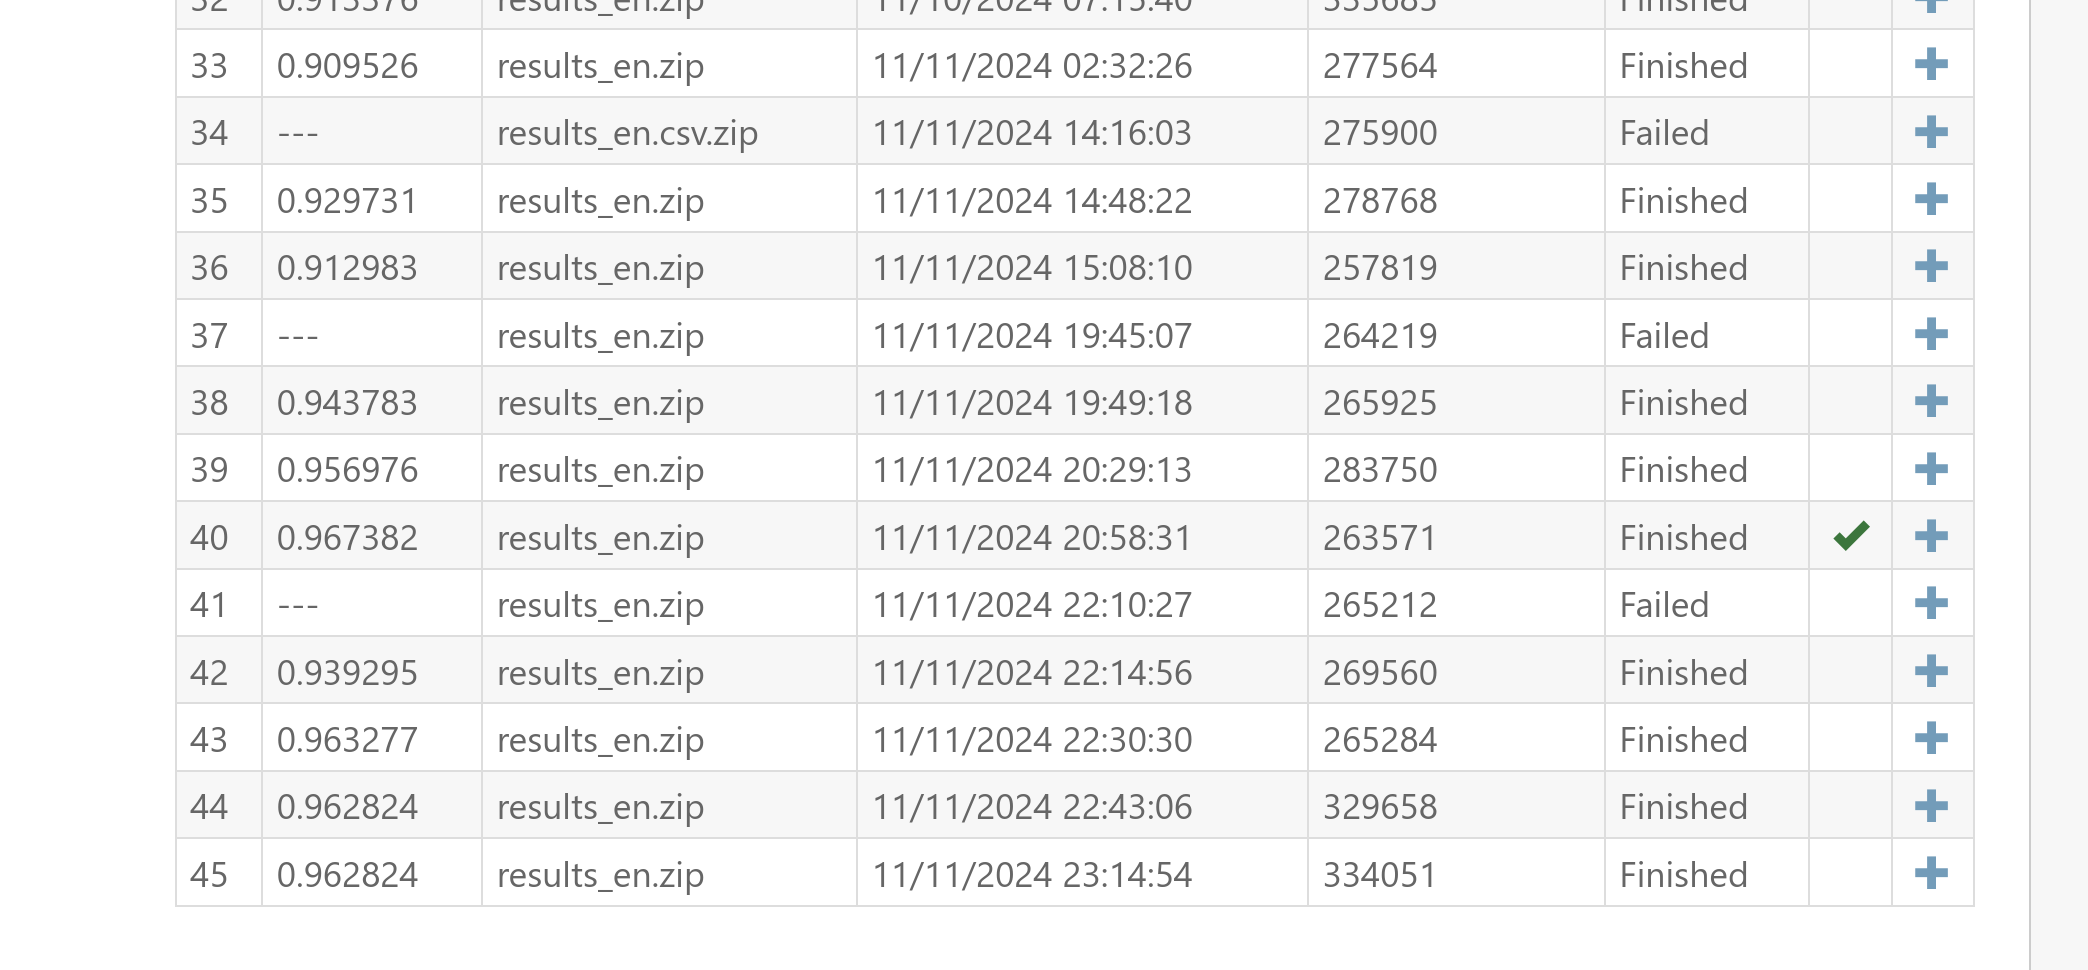